**Loan Status Prediction: Predict Approval for Property Loans** \
This project aims to build a machine learning model predicting loan approval for property loan applicants. We analyze data from past applicants, considering factors like:

Applicant demographics: Gender, Marital status, Dependents, Education
Employment: Self-employed status, Applicant and Co-applicant income
Loan details: Loan amount, term, property area
Financial history: Credit history
Goal: Build a model to accurately classify applicants as approved or rejected based on these features.

Dataset: loan_data.csv contains: 

Unique identifiers: Loan_ID \
Applicant information: Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome \
Loan details: LoanAmount, Loan_Amount_Term, Property_Area \
Credit history: Credit_History \
Target variable: Loan_Status (approved = Y, rejected = N) 

Benefits: This model can help the bank:

Improve loan approval efficiency
Reduce risk of bad loans
Offer personalized loan options

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# import data
loan_data = pd.read_csv('loan_data new.csv')
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0.0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [2]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             381 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    float64
 4   Education          381 non-null    object 
 5   Self_Employed      381 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    object 
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   381 non-null    float64
 10  Credit_History     380 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [3]:
# check for miss data
loan_data.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           8
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       1
Property_Area        0
Loan_Status          0
dtype: int64

In [4]:
# drop missing data
loan_data.dropna(inplace=True)
print('data left =', len(loan_data))
loan_data.isna().sum()

data left = 372


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [5]:
# CoapplicantIncome should be numeric
nans = pd.to_numeric(loan_data['CoapplicantIncome'] , errors="coerce").isna()
print(loan_data['CoapplicantIncome'][nans])

# drop messy data
clean_loan_data = loan_data[~nans]
print(len(clean_loan_data))

# convert CoapplicantIncome
clean_loan_data['CoapplicantIncome'] = clean_loan_data['CoapplicantIncome'].astype(float)

176    9.857.999.877.999.990
273            1.612.000.084
Name: CoapplicantIncome, dtype: object
370


C:\Users\User\AppData\Local\Temp\ipykernel_11128\3481071380.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_loan_data['CoapplicantIncome'] = clean_loan_data['CoapplicantIncome'].astype(float)


In [6]:
# check for categorical data
categorical_df = clean_loan_data.select_dtypes(object)
print(list(categorical_df.columns))

for col in categorical_df.columns:
    if col == 'Loan_ID':
        continue
    
    print(col, ' :', categorical_df[col].value_counts().to_dict())

['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
Gender  : {'Male': 282, 'Female': 83, '0': 5}
Married  : {'Yes': 222, 'No': 148}
Education  : {'Graduate': 271, 'Not Graduate': 99}
Self_Employed  : {'No': 316, 'Yes': 33, '0': 21}
Property_Area  : {'Semiurban': 145, 'Urban': 120, 'Rural': 105}
Loan_Status  : {'Y': 264, 'N': 106}


In [7]:
# drop where gender = 0
no_gender_data = clean_loan_data['Gender'] != '0'
clean_loan_data = clean_loan_data[no_gender_data]

# change missing data in self_employed with Unknown
clean_loan_data['Self_Employed'] = clean_loan_data['Self_Employed'].str.replace('0', 'Unknown')

categorical_df = clean_loan_data.select_dtypes(object)
for col in categorical_df.columns:
    if col == 'Loan_ID':
        continue
    print(col, ' :', categorical_df[col].value_counts().to_dict())

Gender  : {'Male': 282, 'Female': 83}
Married  : {'Yes': 219, 'No': 146}
Education  : {'Graduate': 267, 'Not Graduate': 98}
Self_Employed  : {'No': 311, 'Yes': 33, 'Unknown': 21}
Property_Area  : {'Semiurban': 142, 'Urban': 119, 'Rural': 104}
Loan_Status  : {'Y': 263, 'N': 102}


In [8]:
# check for numeric data
numeric_df = clean_loan_data.select_dtypes(np.number)
print(numeric_df.columns.tolist())

['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [9]:
numeric_df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.676712,3578.654795,1292.057534,104.961644,331.726027,0.780822
std,0.994286,1437.027203,2376.004861,28.561167,87.392329,0.414257
min,0.000000,150.000000,0.000000,9.000000,0.000000,0.000000
25%,0.000000,2583.000000,0.000000,90.000000,360.000000,1.000000
50%,0.000000,3333.000000,997.000000,110.000000,360.000000,1.000000
75%,1.000000,4288.000000,2034.000000,127.000000,360.000000,1.000000
max,3.000000,9703.000000,33837.000000,150.000000,480.000000,1.000000


In [10]:
print(numeric_df['Dependents'].value_counts())
print(numeric_df['Credit_History'].value_counts())

0.0    230
2.0     56
1.0     51
3.0     28
Name: Dependents, dtype: int64
1.0    285
0.0     80
Name: Credit_History, dtype: int64


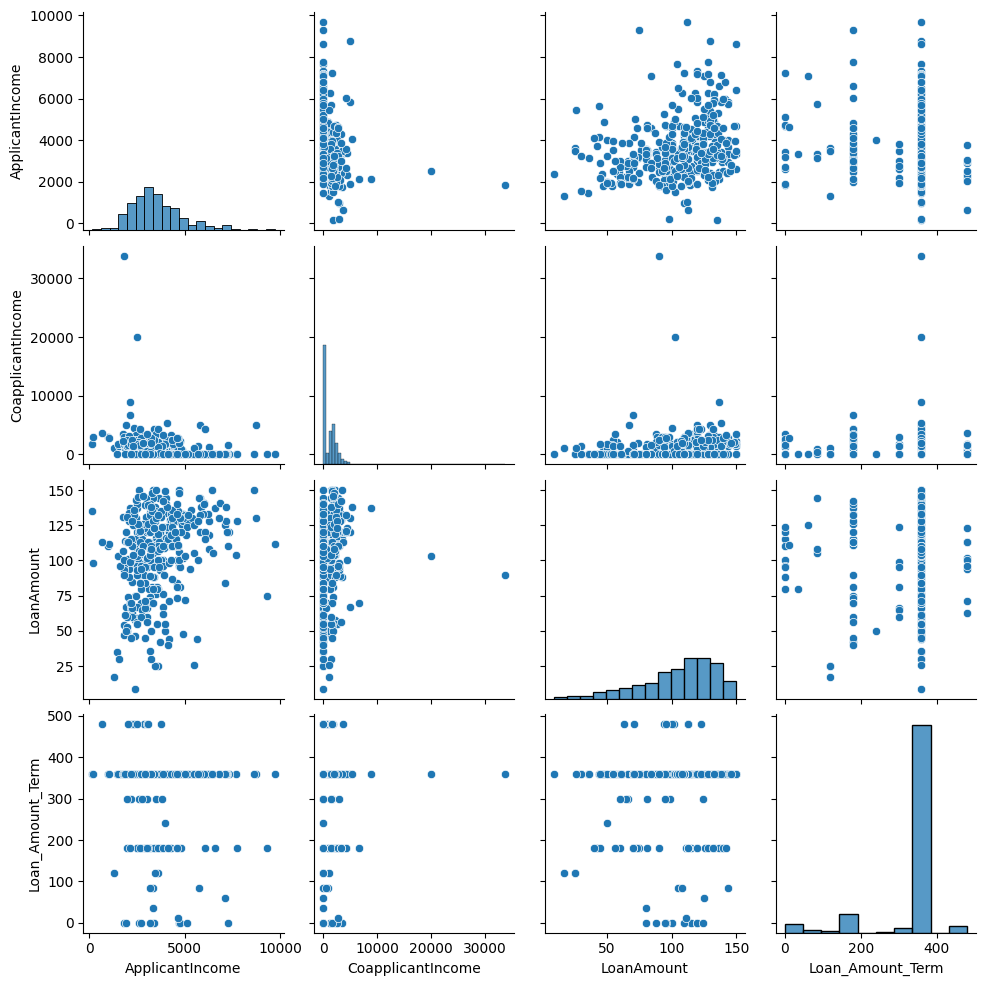

In [11]:
sns.pairplot(numeric_df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']])
plt.show()

In [12]:
# calculate upper lower bound in CoapplicantIncome
avg_coapp_income = numeric_df['CoapplicantIncome'].mean()
std_coapp_income = numeric_df['CoapplicantIncome'].std()
print('Upper CoapplicantIncome 3SD :', avg_coapp_income + 3 * std_coapp_income, 'Lower CoapplicantIncome 3SD :', avg_coapp_income - 3 * std_coapp_income)

# calculate upper lower bound in ApplicantIncome
avg_app_income = numeric_df['ApplicantIncome'].mean()
std_app_income = numeric_df['ApplicantIncome'].std()
print('Upper ApplicantIncome 3SD :', avg_app_income + 3 * std_app_income, 'Lower ApplicantIncome 3SD :', avg_app_income - 3 * std_app_income)

Upper CoapplicantIncome 3SD : 8420.072116510113 Lower CoapplicantIncome 3SD : -5835.957048016961
Upper ApplicantIncome 3SD : 7889.736404085876 Lower ApplicantIncome 3SD : -732.4268150447801


In [13]:
# drop outliers from dataset
outlier_bounded = (clean_loan_data['ApplicantIncome'] < avg_app_income + 3 * std_app_income) \
                     & (clean_loan_data['CoapplicantIncome'] < avg_coapp_income + 3 * std_coapp_income)
clean_loan_data = clean_loan_data[outlier_bounded]
clean_loan_data.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,0.673184,3528.871508,1127.899441,104.787709,331.675978,0.779330
std,0.991226,1319.756981,1250.530030,28.602456,87.802337,0.415279
min,0.000000,150.000000,0.000000,9.000000,0.000000,0.000000
25%,0.000000,2583.000000,0.000000,90.000000,360.000000,1.000000
50%,0.000000,3333.000000,990.000000,110.000000,360.000000,1.000000
75%,1.000000,4268.250000,2012.000000,127.000000,360.000000,1.000000
max,3.000000,7740.000000,6666.000000,150.000000,480.000000,1.000000


In [14]:
# correlation between numeric data
clean_loan_data[numeric_df.columns].corr()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Dependents,1.000000,0.128892,-0.070651,0.082119,-0.046794,-0.005569
ApplicantIncome,0.128892,1.000000,-0.387255,0.286547,-0.105174,0.010599
CoapplicantIncome,-0.070651,-0.387255,1.000000,0.245363,-0.035824,-0.012751
LoanAmount,0.082119,0.286547,0.245363,1.000000,0.082524,-0.013152
Loan_Amount_Term,-0.046794,-0.105174,-0.035824,0.082524,1.000000,0.097288
Credit_History,-0.005569,0.010599,-0.012751,-0.013152,0.097288,1.000000


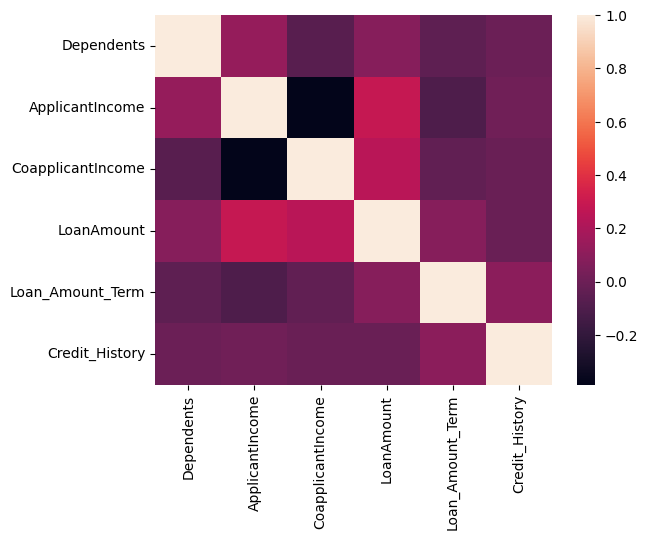

In [15]:
sns.heatmap(clean_loan_data[numeric_df.columns].corr())
plt.show()

In [16]:
clean_loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0.0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


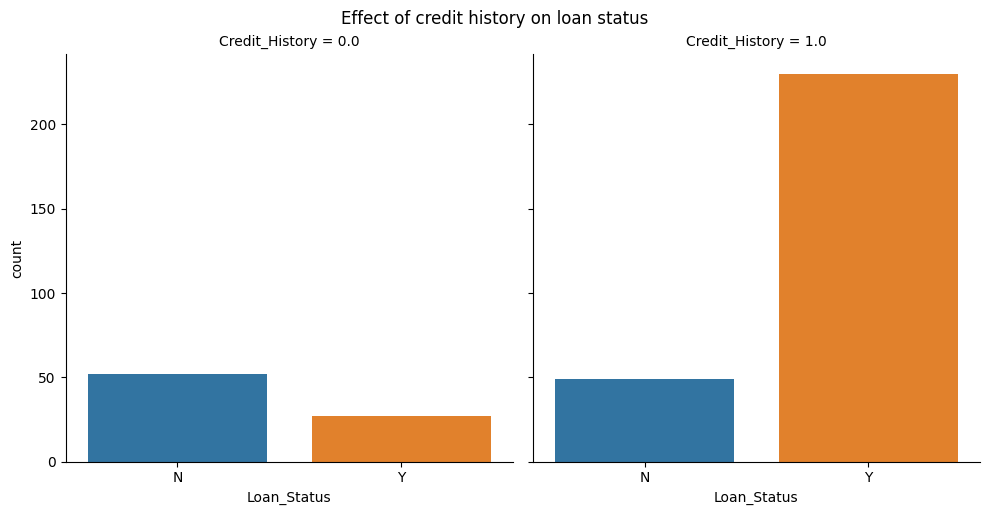

In [17]:
# based on property area category
g = sns.catplot(x="Loan_Status", data=clean_loan_data,
            kind="count",
            col="Credit_History")

g.figure.suptitle("Effect of credit history on loan status", y=1.02)
plt.show()

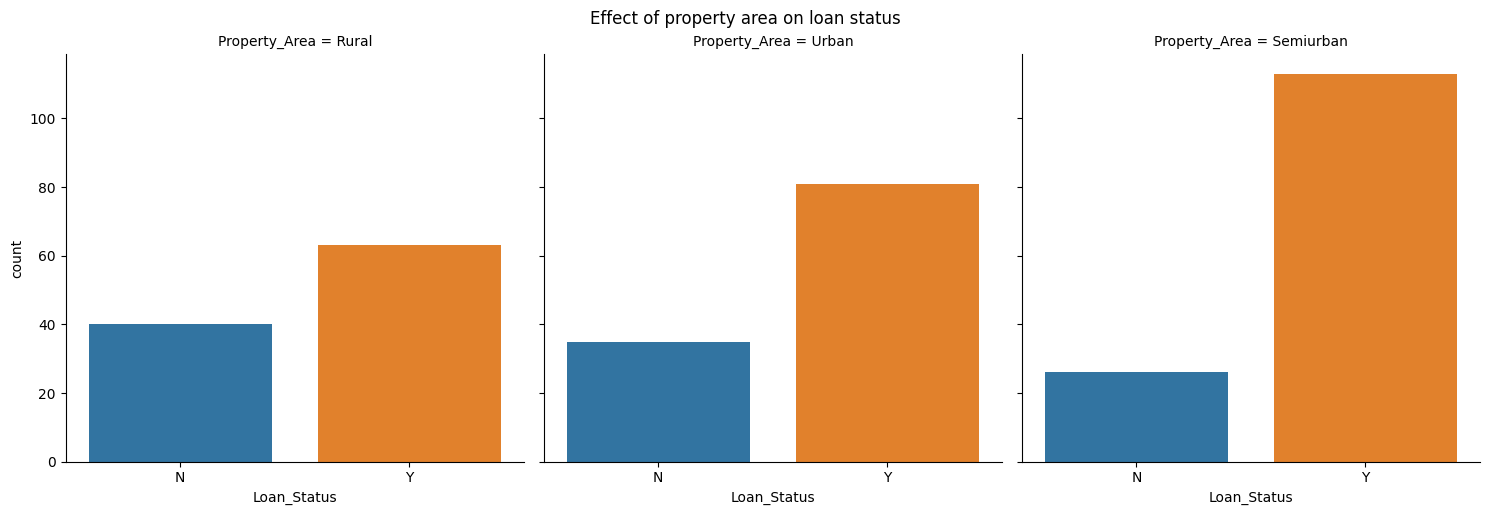

In [18]:
# based on property area category
g = sns.catplot(x="Loan_Status", data=clean_loan_data,
            kind="count",
            col="Property_Area")

g.figure.suptitle("Effect of property area on loan status", y=1.02)
plt.show()

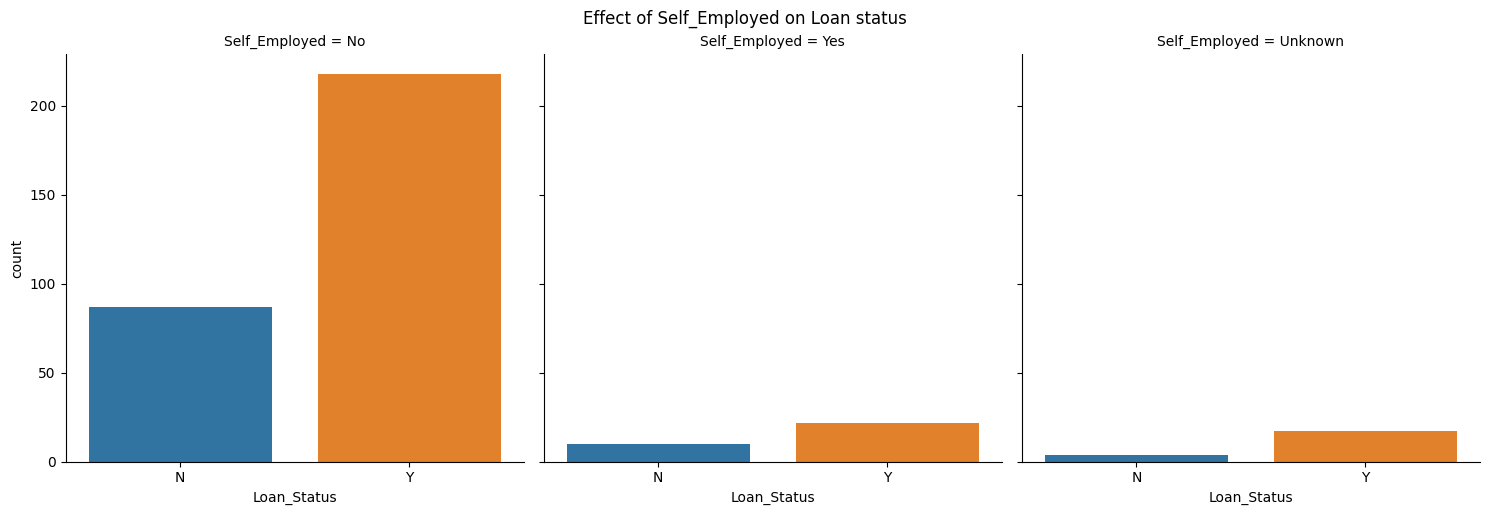

In [19]:
# based on education category
g = sns.catplot(x="Loan_Status", data=clean_loan_data,
            kind="count",
            col="Self_Employed")
g.figure.suptitle("Effect of Self_Employed on Loan status", y=1.02)
plt.show()

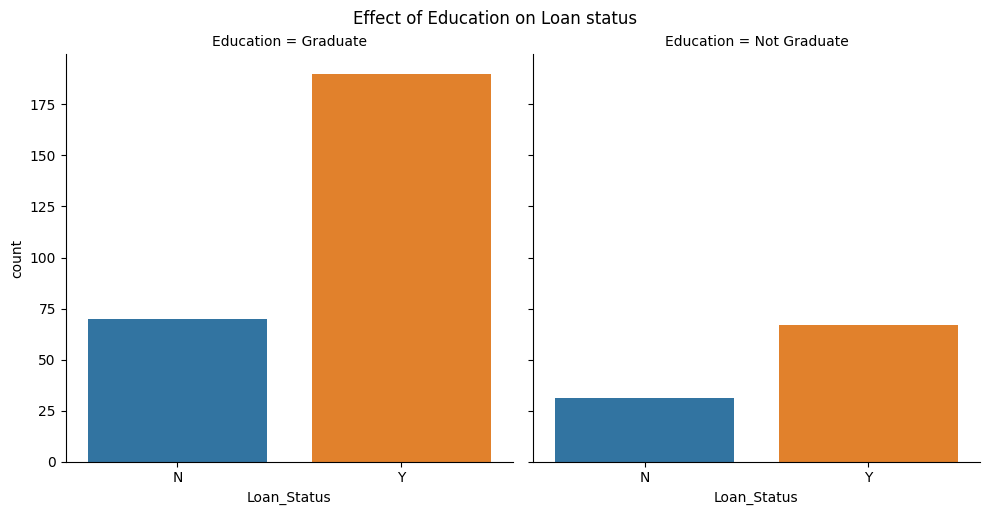

In [20]:
# based on education category
g = sns.catplot(x="Loan_Status", data=clean_loan_data,
            kind="count",
            col="Education")
g.figure.suptitle("Effect of Education on Loan status", y=1.02)
plt.show()

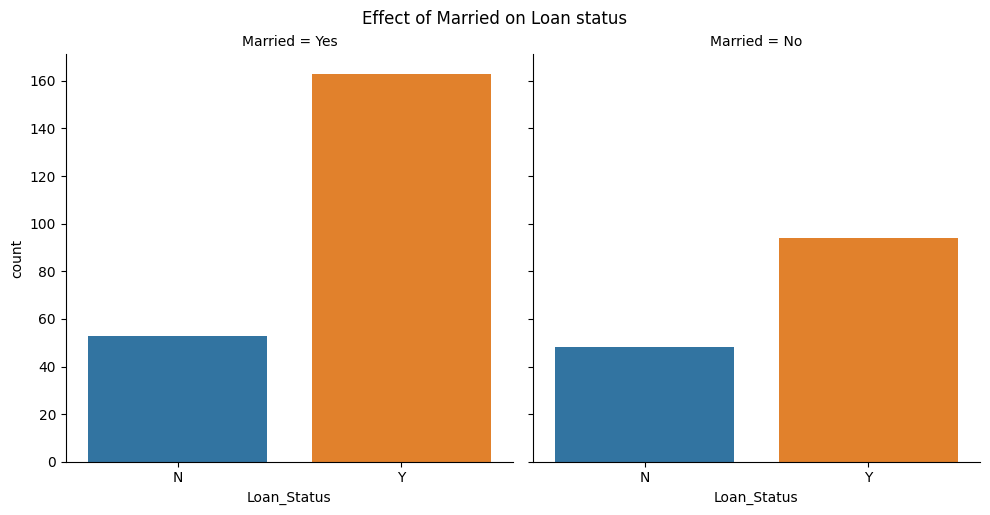

In [21]:
# based on education category
g = sns.catplot(x="Loan_Status", data=clean_loan_data,
            kind="count",
            col="Married")
g.figure.suptitle("Effect of Married on Loan status", y=1.02)
plt.show()

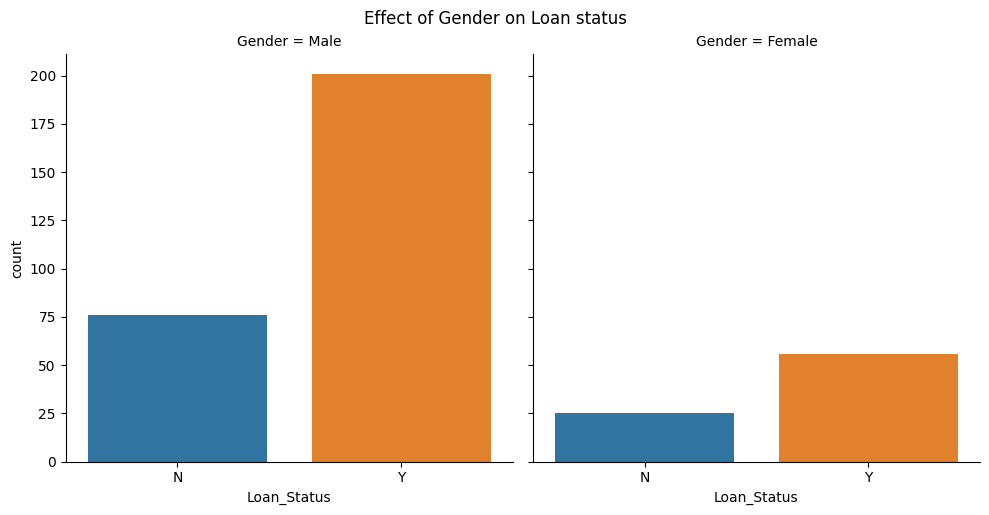

In [22]:
# based on education category
g = sns.catplot(x="Loan_Status", data=clean_loan_data,
            kind="count",
            col="Gender")
g.figure.suptitle("Effect of Gender on Loan status", y=1.02)
plt.show()

##### It look like the most significant feature that effect loan status are 1. credit history that if it bad loan status gonna get denied 2. Property area, seem like property in between urban and rural get highest protion of loan success

In [23]:
clean_loan_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

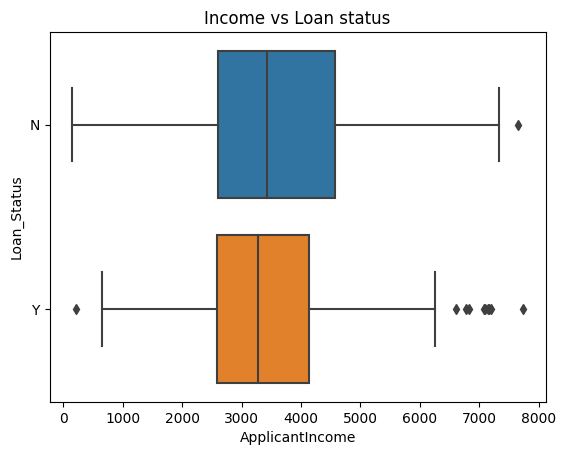

<Figure size 640x480 with 0 Axes>

In [24]:
# Create a boxplot
sns.boxplot(data=clean_loan_data,
         x='ApplicantIncome',
         y='Loan_Status')

plt.title("Income vs Loan status")
plt.show()
plt.clf()

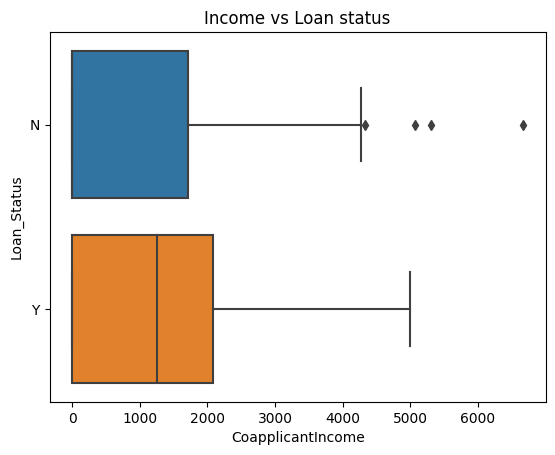

<Figure size 640x480 with 0 Axes>

In [25]:
# Create a boxplot
sns.boxplot(data=clean_loan_data,
         x='CoapplicantIncome',
         y='Loan_Status')

plt.title("Income vs Loan status")
plt.show()
plt.clf()

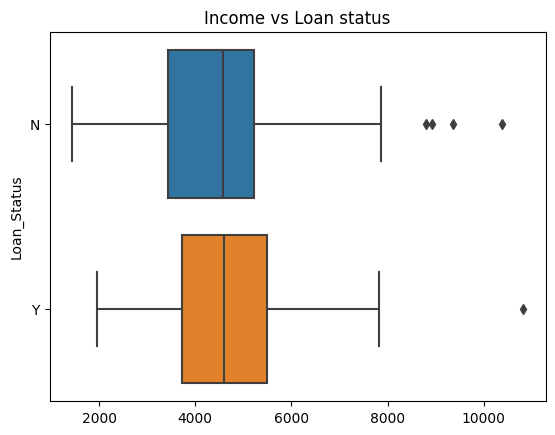

<Figure size 640x480 with 0 Axes>

In [26]:
total_income = clean_loan_data['ApplicantIncome'] + clean_loan_data['CoapplicantIncome']
sns.boxplot(data=clean_loan_data,
         x=total_income,
         y='Loan_Status')

plt.title("Income vs Loan status")
plt.show()
plt.clf()

#### it looks like sum of applicant income and  coapplicant income effect more resaonable than applicant income alone ,since applincant income alone get higher but still doesn't effect loan status that much. This indicate that event applicant has high income but co-applincant has low income loan gonna get denied.

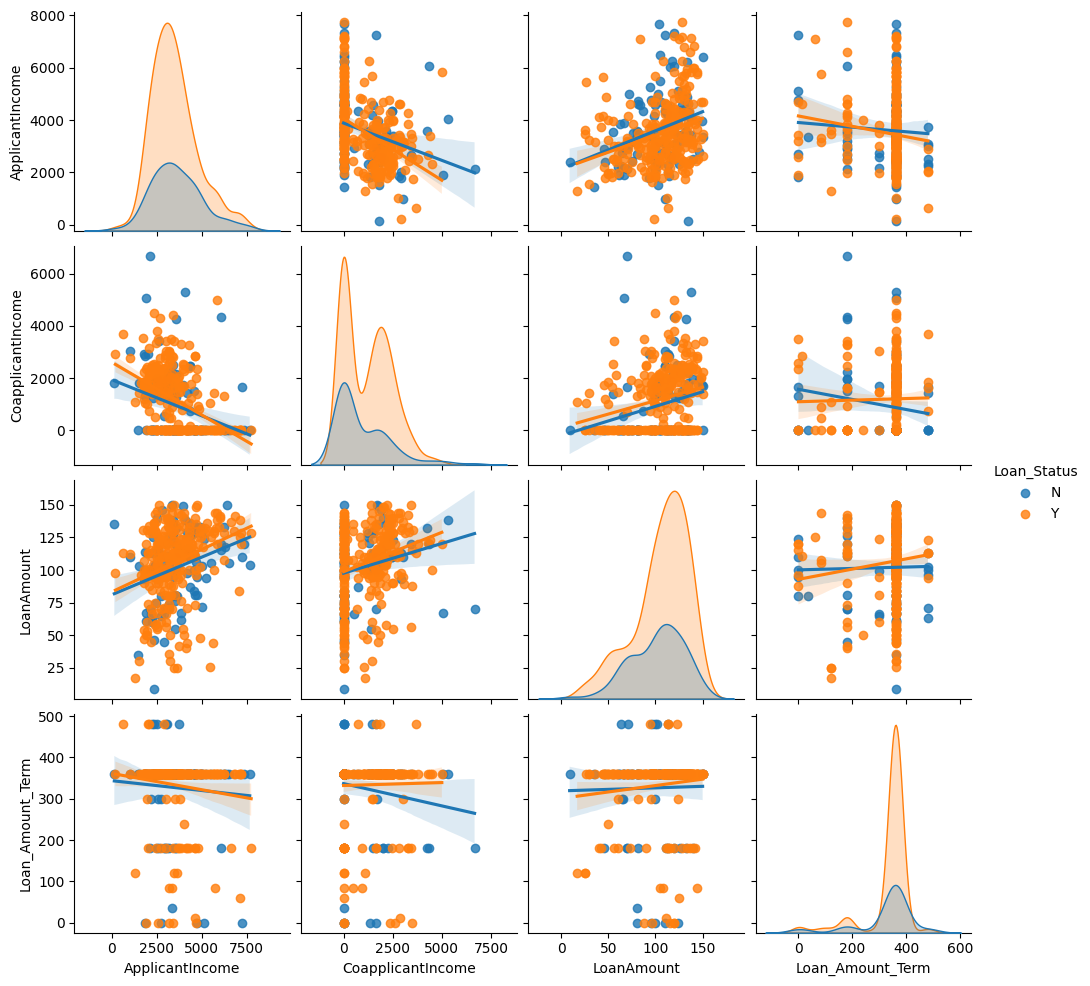

In [27]:
# plot relationships between insurance_losses and premiums
sns.pairplot(data=clean_loan_data,
             vars=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'],
             kind='reg',
             diag_kind = 'kde',
             hue='Loan_Status')

plt.show()

In [28]:
clean_loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0.0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [29]:
for col in ['Gender', 'Married', 'Education', 'Loan_Status']:
    print(col, ' ', clean_loan_data[col].value_counts().to_dict())

Gender   {'Male': 277, 'Female': 81}
Married   {'Yes': 216, 'No': 142}
Education   {'Graduate': 260, 'Not Graduate': 98}
Loan_Status   {'Y': 257, 'N': 101}


In [30]:
# transform data
# binary encoder on Gender, Married, Education, Loan_Status
gender_map = {'Male' : 1, 'Female' : 0}
married_map = {'Yes' : 1, 'No' : 0}
education_map = {'Graduate' : 1, 'Not Graduate' : 0}
loan_status_map = {'Y' : 1, 'N' : 0}

# map feature to binary encode
transform_loan_data = clean_loan_data.copy()
transform_loan_data['Gender'] = transform_loan_data['Gender'].astype('category')
transform_loan_data['Married'] =  transform_loan_data['Married'].astype('category')
transform_loan_data['Education'] = transform_loan_data['Education'].astype('category')
transform_loan_data['Loan_Status'] = transform_loan_data['Loan_Status'].astype('category')
transform_loan_data['Gender'] = transform_loan_data['Gender'].replace(gender_map)
transform_loan_data['Married'] = transform_loan_data['Married'].replace(married_map)
transform_loan_data['Education'] = transform_loan_data['Education'].replace(education_map)
transform_loan_data['Loan_Status'] = transform_loan_data['Loan_Status'].replace(loan_status_map)

# one-hot encode on Self_Employed, Property_Area
self_employed_ohe = pd.get_dummies(transform_loan_data['Self_Employed'], prefix='Self_Employed_')
property_area_ohe = pd.get_dummies(transform_loan_data['Property_Area'], prefix='Property_')

# concat dummies to df
transform_loan_data = pd.concat([transform_loan_data, self_employed_ohe], axis=1)
transform_loan_data = pd.concat([transform_loan_data, property_area_ohe], axis=1)
transform_loan_data.drop(columns=['Self_Employed', 'Property_Area'], inplace=True) 
transform_loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Self_Employed__No,Self_Employed__Unknown,Self_Employed__Yes,Property__Rural,Property__Semiurban,Property__Urban
0,LP001003,1,1,1.0,1,4583,1508.0,128.0,360.0,1.0,0,1,0,0,1,0,0
1,LP001005,1,1,0.0,1,3000,0.0,66.0,360.0,1.0,1,0,0,1,0,0,1
2,LP001006,1,1,0.0,0,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,0,1
3,LP001008,1,0,0.0,1,6000,0.0,141.0,360.0,1.0,1,1,0,0,0,0,1
4,LP001013,1,1,0.0,0,2333,1516.0,95.0,360.0,1.0,1,1,0,0,0,0,1


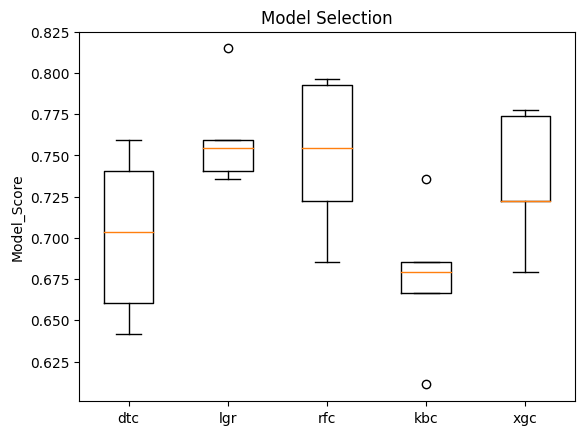

In [40]:
# make features and label variables
X = transform_loan_data.drop(columns=['Loan_ID', 'Loan_Status'])
y = transform_loan_data['Loan_Status']

# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

# model selection
models = {'dtc' : DecisionTreeClassifier(), 
          'lgr' : LogisticRegression(),
          'rfc' : RandomForestClassifier(),
          'kbc' : KNeighborsClassifier(),
          'xgc' : XGBClassifier()}

results = []

# Loop through the models
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=5, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train, y_train, cv=kf)
  results.append(cv_results)

# plot result
plt.boxplot(results, labels=models.keys())
plt.ylabel('Model_Score')
plt.title('Model Selection')
plt.show()

#### there are imbalance in dataset, we will try upsampling deny status to meet number of approve status.

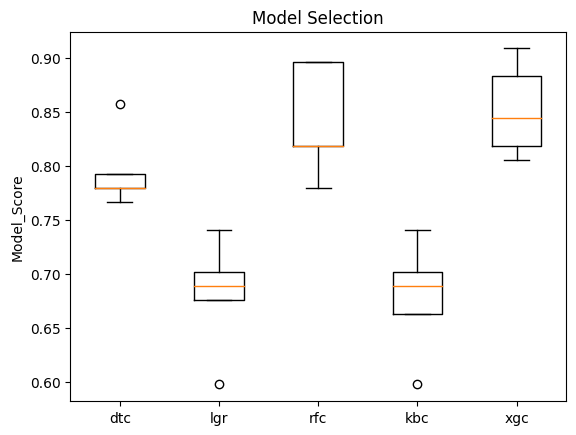

In [42]:
from sklearn.utils import resample

# upsampling dataset
approve = transform_loan_data[transform_loan_data['Loan_Status'] == 1]
deny = transform_loan_data[transform_loan_data['Loan_Status'] == 0]
loans_upsampled = resample(deny, replace=True, n_samples=len(approve), random_state=42)
upsampled = pd.concat([approve, loans_upsampled])

# make features and label variables
X = upsampled.drop(columns=['Loan_ID', 'Loan_Status'])
y = upsampled['Loan_Status']

# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

# model selection
models = {'dtc' : DecisionTreeClassifier(), 
          'lgr' : LogisticRegression(),
          'rfc' : RandomForestClassifier(),
          'kbc' : KNeighborsClassifier(),
          'xgc' : XGBClassifier()}

results = []

# Loop through the models
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=5, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train, y_train, cv=kf)
  results.append(cv_results)

# plot result
plt.boxplot(results, labels=models.keys())
plt.ylabel('Model_Score')
plt.title('Model Selection')
plt.show()

#### it looks like xgboost perfrom better when we upsampling dataset.

#### Make XGboost  hyper parameters tuning

In [44]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 0.9, 1]
}

# make grid search
xgb = XGBClassifier()
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


# best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7}
Best score:  0.8519480519480519


####  Make a pipeline of xgboost with upsampling dataset

In [50]:
# make features and label variables
X = upsampled.drop(columns=['Loan_ID', 'Loan_Status'])
y = upsampled['Loan_Status']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

# Build steps for the pipeline
steps = [("scaler", StandardScaler()), 
         ("xgc", XGBClassifier(learning_rate=0.1, max_depth=7, subsample=0.7))]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print the confusion matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82        73
           1       0.84      0.83      0.83        82

    accuracy                           0.83       155
   macro avg       0.83      0.83      0.83       155
weighted avg       0.83      0.83      0.83       155

